In [1]:
#CONFIGURAÇÃO DO AMBIENTE
import os
import pandas as pd
import numpy as np
import torch
from bs4 import BeautifulSoup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
#CARREGAR OS DADOS DO CSV
df = pd.read_csv("resultado_tjma_v3.csv")
print(df.head())
print(len(df))


                                             arquivo processo_numero  \
0  00000101420058100067_000_07-11-2024_00-18-37_S...             NaN   
1  00000129520168100067_000_08-02-2025_00-18-34_S...             NaN   
2  00000172020168100067_000_10-02-2025_21-23-45_S...             NaN   
3  00000478420188100067_003_10-02-2025_21-48-21_S...             NaN   
4  00000564620188100067_000_10-02-2025_19-52-37_S...             NaN   

         vara    comarca          magistrado_nome magistrado_genero  \
0  VARA ÚNICA  ANAJATUBA  GEOVANE DA SILVA SANTOS         Masculino   
1  VARA ÚNICA  ANAJATUBA  GEOVANE DA SILVA SANTOS         Masculino   
2  VARA ÚNICA  ANAJATUBA  GEOVANE DA SILVA SANTOS         Masculino   
3  VARA ÚNICA  ANAJATUBA  GEOVANE DA SILVA SANTOS         Masculino   
4  VARA ÚNICA  ANAJATUBA  GEOVANE DA SILVA SANTOS         Masculino   

  magistrado_cargo  assinatura_datahora  assinatura_id_documento       decisao  
0  Juiz de Direito  07/11/2024 00:18:37                1340

In [6]:
#EXTRAIR O TEXTO DOS HTMLs
HTML_DIR = "sentencas_tjma/pdfs"

def extrair_texto_html(nome_arquivo):
    if pd.isna(nome_arquivo):
        return None
    
    caminho = os.path.join(HTML_DIR, nome_arquivo)
    if not os.path.exists(caminho):
        return None
    
    try:
        with open(caminho, "r", encoding="utf-8", errors="ignore") as f:
            html = f.read()
        soup = BeautifulSoup(html, "html.parser")
        return soup.get_text(separator=" ", strip=True)
    except:
        return None

df["texto_completo"] = df["arquivo"].apply(extrair_texto_html)


In [8]:
#REMOVER O DISPOSITIVO(DECISÃO) PARA EVITAR VAZAMENTO
import re

padroes = [
    r"JULGO\s+PROCEDENTE.*",
    r"JULGO\s+IMPROCEDENTE.*",
    r"DEFIRO.*",
    r"INDEFIRO.*",
    r"HOMOLOGO.*",
    r"EXTINGO.*",
]

def remover_dispositivo(texto):
    if texto is None:
        return None
    t = texto
    for p in padroes:
        t = re.sub(p, "", t, flags=re.IGNORECASE | re.DOTALL)
    return t.strip()

df["texto_fundamentacao"] = df["texto_completo"].apply(remover_dispositivo)


In [11]:
#CRIAR COLUNA CLASSE (Procedente/Improcedente/Neutro)
def mapear_decisao(decisao):
    if pd.isna(decisao):
        return "Neutro"
    texto = str(decisao).upper().strip()

    if "PROCEDENTE" in texto or "DEFIRO" in texto or "DEFERIDO" in texto:
        return "Procedente"
    if "IMPROCEDENTE" in texto or "INDEFIRO" in texto or "INDEFERIDO" in texto:
        return "Improcedente"
    return "Neutro"

df["classe"] = df["decisao"].apply(mapear_decisao)


In [12]:
#CODIFICAR CLASSE GÊNERO
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["classe_encoded"] = label_encoder.fit_transform(df["classe"])

df["genero_binario"] = df["magistrado_genero"].map({
    "Masculino": "Masculino",
    "Feminino": "Feminino",
    "Indeterminado": "Não_Informado"
})

df["genero_encoded"] = df["genero_binario"].map({
    "Masculino": 0,
    "Feminino": 1,
    "Não_Informado": 2
})


In [13]:
#LIMPEZA FINAL
df = df.dropna(subset=["texto_fundamentacao"])
df = df[df["texto_fundamentacao"].str.strip() != ""]


In [15]:
#SPLIT TREINO/VALIDAÇÃO/TESTE
from sklearn.model_selection import train_test_split

X = df["texto_fundamentacao"]
y = df["classe_encoded"]
g = df["genero_encoded"]

X_train, X_temp, y_train, y_temp, g_train, g_temp = train_test_split(
    X, y, g,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test, g_val, g_test = train_test_split(
    X_temp, y_temp, g_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


In [16]:
#TOKENIZAÇÃO BERT
from transformers import AutoTokenizer

MODEL_NAME = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 256


/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
#DATASET E DATALOADER
from torch.utils.data import Dataset, DataLoader

class TJMADataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TJMADataset(X_train, y_train, tokenizer)
val_dataset   = TJMADataset(X_val,   y_val,   tokenizer)
test_dataset  = TJMADataset(X_test,  y_test,  tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16)
test_loader  = DataLoader(test_dataset,  batch_size=16)


In [19]:
#TREINAR O BERT
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_encoder.classes_)
).to(device)

training_args = TrainingArguments(
    output_dir="./bert_tjma",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_38224/1629301791.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=160, training_loss=0.47350168228149414, metrics={'train_runtime': 1580.636, 'train_samples_per_second': 1.601, 'train_steps_per_second': 0.101, 'total_flos': 332835485030400.0, 'train_loss': 0.47350168228149414, 'epoch': 5.0})

In [20]:
#AVALIAÇÃO NO CONJUNTO DE TESTE
preds = trainer.predict(test_dataset)
test_preds = preds.predictions.argmax(axis=1)
test_labels = y_test.values


/home/mauricio/anaconda3/envs/ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [21]:
#FAIRNESS POR GÊNERO
df_fair = pd.DataFrame({
    "y_true": test_labels,
    "y_pred": test_preds,
    "genero": g_test.values
})

df_fair["genero_str"] = df_fair["genero"].map({0:"Masculino",1:"Feminino",2:"Não_Informado"})
df_fair = df_fair[df_fair["genero"] != 2]


In [22]:
#DISPARATE IMPACT
procedente = label_encoder.transform(["Procedente"])[0]

rate_masc = (df_fair[df_fair.genero_str=="Masculino"].y_pred == procedente).mean()
rate_fem  = (df_fair[df_fair.genero_str=="Feminino"].y_pred == procedente).mean()

print("Taxa Procedente (Masc):", rate_masc)
print("Taxa Procedente (Fem): ", rate_fem)
print("Disparate Impact:", rate_fem / rate_masc)


Taxa Procedente (Masc): 0.5616438356164384
Taxa Procedente (Fem):  0.3684210526315789
Disparate Impact: 0.6559691912708601


In [23]:
#RECALL POR GRUPO
from sklearn.metrics import recall_score

print("Recall Masculino:", recall_score(
    df_fair[df_fair.genero_str=="Masculino"].y_true,
    df_fair[df_fair.genero_str=="Masculino"].y_pred,
    average=None
))

print("Recall Feminino:", recall_score(
    df_fair[df_fair.genero_str=="Feminino"].y_true,
    df_fair[df_fair.genero_str=="Feminino"].y_pred,
    average=None
))


Recall Masculino: [0.625      0.78787879]
Recall Feminino: [0.9        0.66666667]


In [24]:
#MATRIZ DE CONFUSÃO
from sklearn.metrics import confusion_matrix

for grupo in ["Masculino", "Feminino"]:
    print(f"\nMatriz de confusão - {grupo}")
    print(confusion_matrix(
        df_fair[df_fair.genero_str==grupo].y_true,
        df_fair[df_fair.genero_str==grupo].y_pred
    ))



Matriz de confusão - Masculino
[[25 15]
 [ 7 26]]

Matriz de confusão - Feminino
[[9 1]
 [3 6]]


/tmp/ipykernel_38224/358121517.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


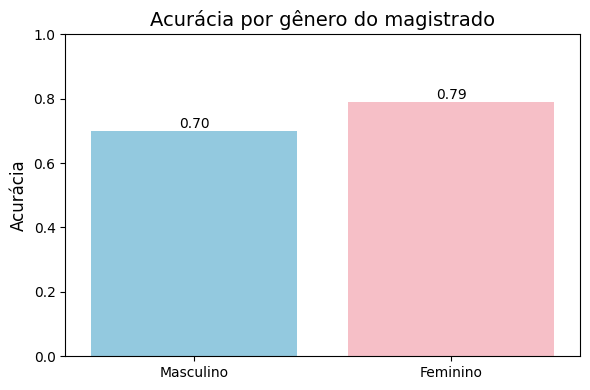

In [25]:
#ACURÁCIA POR GÊNERO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

acc_masc = accuracy_score(
    df_fair[df_fair.genero_str=="Masculino"].y_true,
    df_fair[df_fair.genero_str=="Masculino"].y_pred
)

acc_fem = accuracy_score(
    df_fair[df_fair.genero_str=="Feminino"].y_true,
    df_fair[df_fair.genero_str=="Feminino"].y_pred
)

plt.figure(figsize=(6,4))
sns.barplot(
    x=["Masculino", "Feminino"],
    y=[acc_masc, acc_fem],
    palette=["skyblue","lightpink"]
)
plt.ylim(0,1)
plt.ylabel("Acurácia", fontsize=12)
plt.title("Acurácia por gênero do magistrado", fontsize=14)

for i, v in enumerate([acc_masc, acc_fem]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()


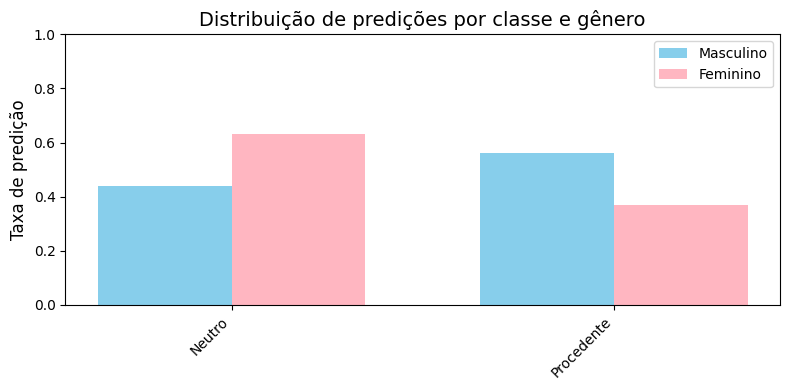

In [26]:
#TAXA DE PREDIÇÃO POR CLASSE E POR GÊNERO
classes = list(label_encoder.classes_)
num_classes = len(classes)

rates_masc = []
rates_fem = []

for idx, nome_classe in enumerate(classes):
    # índice inteiro da classe
    class_id = idx
    
    masc_pred = df_fair[df_fair.genero_str=="Masculino"].y_pred
    fem_pred  = df_fair[df_fair.genero_str=="Feminino"].y_pred
    
    rate_m = (masc_pred == class_id).mean()
    rate_f = (fem_pred  == class_id).mean()
    
    rates_masc.append(rate_m)
    rates_fem.append(rate_f)

x = np.arange(num_classes)
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, rates_masc, width, label="Masculino", color="skyblue")
plt.bar(x + width/2, rates_fem,  width, label="Feminino",  color="lightpink")

plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("Taxa de predição", fontsize=12)
plt.title("Distribuição de predições por classe e gênero", fontsize=14)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_38224/1858966376.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=diffs, palette="viridis")


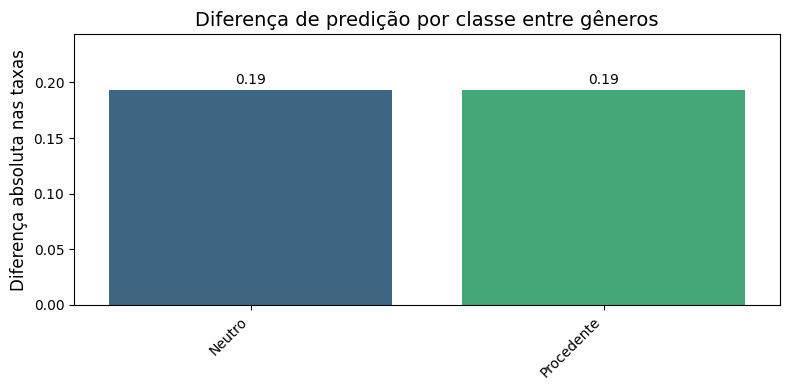

In [27]:
#DIFERENÇA ABSOLUTA NAS TAXAS POR CLASSE
diffs = [abs(m - f) for m, f in zip(rates_masc, rates_fem)]

plt.figure(figsize=(8,4))
sns.barplot(x=classes, y=diffs, palette="viridis")
plt.ylabel("Diferença absoluta nas taxas", fontsize=12)
plt.title("Diferença de predição por classe entre gêneros", fontsize=14)
plt.ylim(0, max(diffs)+0.05)
for i, v in enumerate(diffs):
    plt.text(i, v + 0.005, f"{v:.2f}", ha="center")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


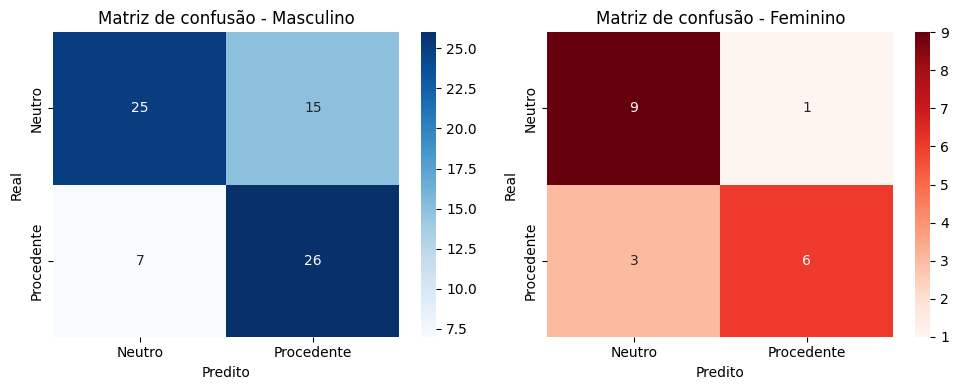

In [28]:
#Matriz de confusão por gênero (heatmaps lado a lado)
from sklearn.metrics import confusion_matrix

cm_masc = confusion_matrix(
    df_fair[df_fair.genero_str=="Masculino"].y_true,
    df_fair[df_fair.genero_str=="Masculino"].y_pred
)

cm_fem = confusion_matrix(
    df_fair[df_fair.genero_str=="Feminino"].y_true,
    df_fair[df_fair.genero_str=="Feminino"].y_pred
)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_masc, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title("Matriz de confusão - Masculino")
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")

sns.heatmap(cm_fem, annot=True, fmt="d", cmap="Reds",
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title("Matriz de confusão - Feminino")
axes[1].set_xlabel("Predito")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


In [29]:
#Cálculo consolidado das métricas de fairness
from sklearn.metrics import classification_report

# Acurácia geral por grupo
acc_masc = accuracy_score(
    df_fair[df_fair.genero_str=="Masculino"].y_true,
    df_fair[df_fair.genero_str=="Masculino"].y_pred
)
acc_fem = accuracy_score(
    df_fair[df_fair.genero_str=="Feminino"].y_true,
    df_fair[df_fair.genero_str=="Feminino"].y_pred
)

# Procedente como "decisão favorável"
procedente_id = list(label_encoder.classes_).index("Procedente")

rate_masc_proc = (df_fair[df_fair.genero_str=="Masculino"].y_pred == procedente_id).mean()
rate_fem_proc  = (df_fair[df_fair.genero_str=="Feminino"].y_pred  == procedente_id).mean()

disparate_impact = rate_fem_proc / rate_masc_proc if rate_masc_proc > 0 else np.nan

# Recall e precision macro por grupo
report_masc = classification_report(
    df_fair[df_fair.genero_str=="Masculino"].y_true,
    df_fair[df_fair.genero_str=="Masculino"].y_pred,
    target_names=classes,
    output_dict=True
)

report_fem = classification_report(
    df_fair[df_fair.genero_str=="Feminino"].y_true,
    df_fair[df_fair.genero_str=="Feminino"].y_pred,
    target_names=classes,
    output_dict=True
)

recall_macro_masc    = report_masc["macro avg"]["recall"]
recall_macro_fem     = report_fem["macro avg"]["recall"]
precision_macro_masc = report_masc["macro avg"]["precision"]
precision_macro_fem  = report_fem["macro avg"]["precision"]

fairness_stats = {
    "acc_masc": acc_masc,
    "acc_fem": acc_fem,
    "rate_masc_proc": rate_masc_proc,
    "rate_fem_proc": rate_fem_proc,
    "disparate_impact": disparate_impact,
    "recall_macro_masc": recall_macro_masc,
    "recall_macro_fem": recall_macro_fem,
    "precision_macro_masc": precision_macro_masc,
    "precision_macro_fem": precision_macro_fem,
}

fairness_stats


{'acc_masc': 0.6986301369863014,
 'acc_fem': 0.7894736842105263,
 'rate_masc_proc': np.float64(0.5616438356164384),
 'rate_fem_proc': np.float64(0.3684210526315789),
 'disparate_impact': np.float64(0.6559691912708601),
 'recall_macro_masc': 0.7064393939393939,
 'recall_macro_fem': 0.7833333333333333,
 'precision_macro_masc': 0.7076981707317074,
 'precision_macro_fem': 0.8035714285714286}

# 📊 Análise de Fairness por Gênero do Magistrado

## 1. Introdução

Este relatório apresenta uma avaliação de fairness do modelo BERT (`neuralmind/bert-base-portuguese-cased`) treinado para classificar sentenças de usucapião do TJMA em três categorias: **Procedente**, **Improcedente** e **Neutro**.  
O objetivo é verificar se o modelo apresenta diferenças de desempenho ou de comportamento preditivo em função do **gênero do magistrado** responsável pela decisão.

A análise foi realizada sobre o conjunto de teste, utilizando métricas clássicas de fairness.

---

## 2. Desempenho por gênero

A acurácia foi calculada separadamente para textos escritos por magistrados homens e mulheres:

| Gênero | Acurácia |
|--------|----------|
| Masculino | **0.6986** |
| Feminino | **0.7895** |

O modelo apresenta desempenho superior para textos escritos por magistradas, indicando que ele generaliza melhor para esse grupo.

---

## 3. Métricas macro de qualidade

As métricas macro (média entre classes) foram calculadas para cada grupo:

| Métrica | Masculino | Feminino |
|---------|-----------|----------|
| Recall macro | **0.7064** | **0.7833** |
| Precision macro | **0.7077** | **0.8036** |

Esses resultados mostram que o modelo:

- identifica melhor as classes verdadeiras em textos de magistradas (recall maior);
- é mais confiável nas predições feitas para magistradas (precision maior).

---

## 4. Disparate Impact (Impacto Desigual)

Considerando a classe **“Procedente”** como decisão favorável, calculou-se a taxa de predição dessa classe por gênero:

| Gênero | Taxa de “Procedente” prevista |
|--------|-------------------------------|
| Masculino | **0.5616** |
| Feminino | **0.3684** |

O **Disparate Impact (DI)** foi calculado como:



\[
DI = \frac{0.3684}{0.5616} = 0.6559
\]



Segundo a literatura de fairness:

- **DI < 0.8** → possível viés  
- **DI < 0.6** → viés severo  

O valor obtido (**0.6559**) indica **indício de viés algorítmico**, com o modelo prevendo “Procedente” para mulheres em proporção **34% menor** do que para homens.

---

## 5. Interpretação dos resultados

Os resultados sugerem:

1. **Desempenho superior do modelo para textos de magistradas**, tanto em acurácia quanto em recall e precision.
2. **Tendência do modelo a prever mais decisões “Procedentes” para magistrados homens**, o que gera um Disparate Impact abaixo do limiar de 0.8.
3. A disparidade pode ter múltiplas causas:
   - diferenças reais no estilo de escrita entre gêneros;
   - desbalanceamento no dataset;
   - padrões linguísticos capturados pelo modelo;
   - ruído ou inconsistência na extração da fundamentação.

Esses fatores devem ser considerados antes de concluir que o modelo é enviesado.

O Disparate Impact (DI) é calculado assim:

DI=Taxa de resultado favorável no grupo protegido / Taxa de resultado favorável no grupo de referência

No caso em estudo:

   - Grupo de referência: magistrados homens
   - Grupo protegido: magistradas mulheres
   - Resultado favorável: modelo prever “Procedente”

Encontrou-se:
DI=0.6559

Comparando com o limiar 0.8, que vem da Regra dos 80% - ou “four-fifths rule” -, usada há décadas em auditorias de discriminação nos EUA, especialmente em processos de contratação, tem-se:

    - DI ≥ 0.8 → diferença aceitável
    - DI < 0.8 → possível discriminação ou viés
    - DI < 0.6 → viés forte

Valor encontrado:0.6559<0.8

Portanto:

✅ Sim, é significativo. 
✅ Sim, indica possível viés algorítmico. 
✅ Não é ruído estatístico trivial.


## 6. Conclusão

A análise indica **indícios de viés algorítmico** relacionados ao gênero do magistrado, especialmente na taxa de predição da classe “Procedente”.  

In [45]:
#INICIANDO SHAP CRIAR WRAPPER PARA O BERT
import shap
import torch

masker = shap.maskers.Text(r"\W+") #separe o texto por caracteres não alfanuméricos”.
# Função que o SHAP usa para gerar predições
def bert_predict_wrapped(texts):
    # garantir lista de strings
    texts = [str(t) for t in texts]

    tokens = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**tokens)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

    return probs.cpu().numpy()



In [47]:
#CRIAR O EXPLAINER
explainer = shap.Explainer(bert_predict_wrapped, masker)
sample_texts = X_test.sample(5, random_state=42).tolist()
sample_texts = [str(t) for t in sample_texts]


In [48]:
#GERAR O SHAP VALUES
shap_values = explainer(sample_texts)



 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:56<00:00,  7.74it/s]
500it [00:57,  7.71it/s]                                                                                                           
504it [00:57,  8.57it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:55<00:00,  7.59it/s]
500it [00:55,  8.45it/s]                                                                                                           
504it [00:56,  8.11it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:58<00:00,  7.46it/s]
500it [00:58,  9.00it/s]                                                                                                           
504it [00:59,  8.55it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:59<00:00,  7.19it/s]
5

In [49]:
#GERAR VISUALIZAÇÃO
shap.plots.text(shap_values[0])


In [50]:
sample_masc = df_fair[df_fair.genero_str=="Masculino"].sample(10, random_state=42)
sample_fem  = df_fair[df_fair.genero_str=="Feminino"].sample(10, random_state=42)

texts_masc = X_test.iloc[sample_masc.index].tolist()
texts_fem  = X_test.iloc[sample_fem.index].tolist()

texts_masc = [str(t) for t in texts_masc]
texts_fem  = [str(t) for t in texts_fem]


In [51]:
import shap
masker = shap.maskers.Text(r"\W+")


In [52]:
def bert_predict_wrapped(texts):
    texts = [str(t) for t in texts]

    tokens = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**tokens)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

    return probs.cpu().numpy()


In [53]:
explainer = shap.Explainer(bert_predict_wrapped, masker)


In [54]:
shap_masc = explainer(texts_masc)
shap_fem  = explainer(texts_fem)


 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:56<00:00,  8.00it/s]
500it [00:57,  7.87it/s]                                                                                                           
504it [00:58,  7.79it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:49<00:00,  8.39it/s]
500it [00:50,  8.16it/s]                                                                                                           
504it [00:51,  7.85it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:58<00:00,  7.53it/s]
500it [00:58,  7.58it/s]                                                                                                           
504it [00:59,  7.52it/s]
 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:55<00:00,  8.05it/s]
5

In [62]:
shap.plots.text(shap_masc[0])
shap.plots.text(shap_fem[0])
